<a href="https://colab.research.google.com/github/nadya1462/sirius_2022/blob/main/Lection_2_Biophysical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biophysical models
Here we have implemented the conductance-based model from Chapter 2 of Neuronal Dynamics.
https://neuronaldynamics.epfl.ch/online/Ch2.S2.html

There is no homework on this topic.

In [ ]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 30.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 22.8 MB/s 
     |████████████████████████████████| 944 kB 45.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:

import matplotlib.pyplot as plt

def plot_v(v_mon, v_threshold = None, t_bounds=None):
    #plt.subplot(211)
    plt.plot(v_mon.t/ms, v_mon.v[0]/mvolt, label='Membrane voltage')
    plt.xlabel('Time (ms)')
    plt.ylabel('v (mV)')
    if t_bounds:
        plt.xlim(t_bounds)
    if v_threshold:
        plt.axhline(v_threshold/mvolt, ls='--', c='C2', label='threshold') #plot threshold


def plot_I(mon, current, t_bounds=None):
    plt.xlabel('Time (ms)')
    plt.ylabel('I (nA)')
    if t_bounds:
        plt.xlim(t_bounds)
    plt.plot(mon.t / ms, current(mon.t)/namp, "r", lw=2,
            label='Input current') 
    
def plot_gating(mon, t_bounds=None):
    plt.plot(mon.t / ms, mon.m[0],
            label='Na activation (m)')
    plt.plot(mon.t / ms, mon.n[0],
            label='Na inactivation (n)')
    plt.plot(mon.t / ms, mon.h[0],
            label='K activation (h)')
    if t_bounds:
        plt.xlim(t_bounds)
    plt.xlabel('Time (ms)')
    plt.ylabel('Gating variables')
    plt.legend();
   
    

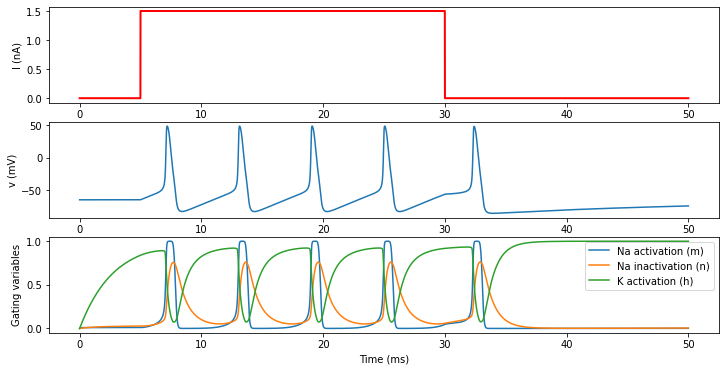

In [ ]:
from brian2 import *
start_scope()
num_neurons = 1
duration = 50*ms

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
I_subthres = 0.5
I_low = 1.5
I_high = 2.5
I_arr = [0]*1 + [I_low]*5 + [0]*1
I = TimedArray(I_arr * nA, dt=5 * ms)
# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
''')
# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El


#group.I = '0.7*nA'
#group.I = I

s_monitor = SpikeMonitor(group)
v_monitor = StateMonitor(group, ["v","m","n","h"], record=True)
defaultclock.dt = 0.01*ms
run(duration)

fig = figure(figsize=(12,6))
subplot(3,1,1)
plot_I(v_monitor, I)
subplot(3,1,2)
plot_v(v_monitor)
subplot(3,1,3)
plot_gating(v_monitor)


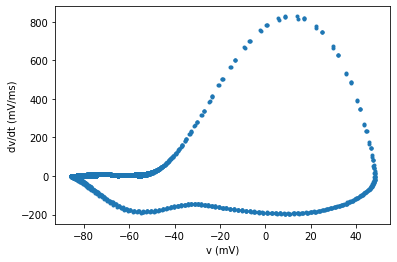

In [ ]:
import numpy as np
def phase_var(v_mon, s_mon):
    dv_dt = np.diff(v_mon.v[0])/np.diff(v_mon.t)
    v = v_mon.v[0,1:]
    return v, dv_dt

def phase_var_grad(v_mon):
    dv_dt = np.gradient(v_mon.v[0]/mV, v_mon.t/ms)*mV/ms
    #v = v_mon.v[0,1:]
    return v_mon.v[0], dv_dt

def plot_phaseplane_bound(v_mon):
    #v, dv_dt = phase_var(v_mon, s_mon)
    v, dv_dt = phase_var_grad(v_mon)
    plt.plot(v/mV, dv_dt/mV*ms, '.')
    plt.xlabel('v (mV)')
    plt.ylabel('dv/dt (mV/ms)')
    
plot_phaseplane_bound(v_monitor)